
# Лабораторная работа №3

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

##### Выполнил: Борисочкин М. И., РТ5-61Б


### Текстовое описание набора данных

Для обучения по методу K ближайших соседей (KNN) был выбран датасет с классификацией типа звёзд c ресурса kaggle ([Star Type Classification / NASA](https://www.kaggle.com/datasets/brsdincer/star-type-classification))

В данном наборе данных присутствуют следующие столбцы:
- Temperature — температура звезды в Кельвинах;
- L (Luminosity) — светимость звезды в солнечных светимостях;
- R (Radius) — радиус звезды в радиусах солнца;
- A_M (Absolute Magnitude) — [абсолютная звёздная величина](https://ru.wikipedia.org/wiki/%D0%90%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D0%B0%D1%8F_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4%D0%BD%D0%B0%D1%8F_%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D0%B0);
- Color — цвет света звезды;
- Spectral_Class — [спектральный класс звезды](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4);
- Type — тип звезды. Является целевым признаком и уже закодирован:
    - Красный карлик — 0;
    - Коричневый карлик — 1;
    - Белый карлик — 2;
    - Звезда из [главной последовательности](https://ru.wikipedia.org/wiki/%D0%93%D0%BB%D0%B0%D0%B2%D0%BD%D0%B0%D1%8F_%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C) — 3;
    - Супергигант — 4;
    - Гипергигант — 5.


### Импорт библиотек


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks')


### Загрузка данных


In [2]:
# Загрузка датасета
data = pd.read_csv('data/Stars.csv')


### Разведочный анализ данных


In [3]:
# Первые пять строк датасета
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [4]:
# Последние пять строк датасета
data.tail()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
235,38940,374830.0,1356.0,-9.93,Blue,O,5
236,30839,834042.0,1194.0,-10.63,Blue,O,5
237,8829,537493.0,1423.0,-10.73,White,A,5
238,9235,404940.0,1112.0,-11.23,White,A,5
239,37882,294903.0,1783.0,-7.80,Blue,O,5


In [5]:
# Размер датасета
data.shape

(240, 7)

In [6]:
# Типы столбцов
data.dtypes

Temperature         int64
L                 float64
R                 float64
A_M               float64
Color              object
Spectral_Class     object
Type                int64
dtype: object

In [7]:
# Пустые значения
data.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

In [8]:
# Дублирующиеся значения
data.duplicated().sum()

0

In [9]:
# Статистические характеристки датасета
data.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


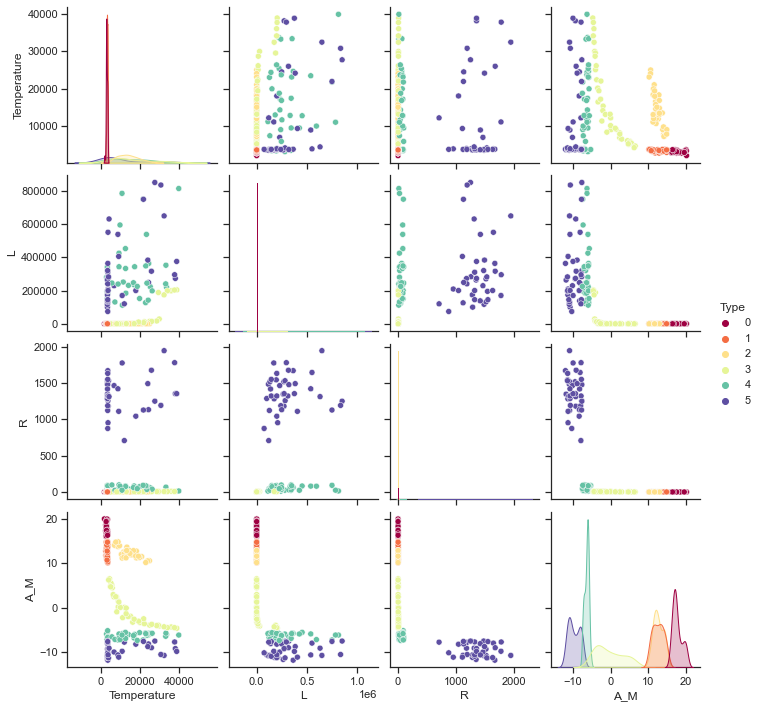

In [10]:
# Парные диаграммы
sns.pairplot(data=data, hue='Type', palette='Spectral')
plt.show()

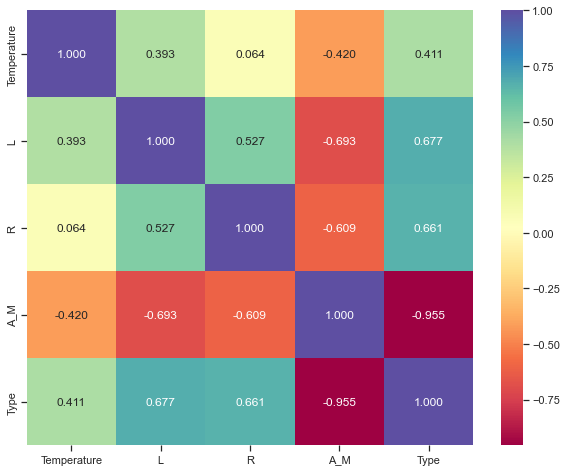

In [11]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), annot=True, fmt='.3f', cmap='Spectral')
plt.show()

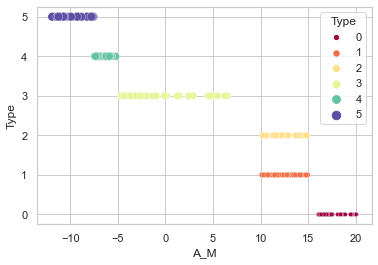

In [12]:
# Диаграмма рассеивания абсолютной звёздной величины и типа звезды
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=data, x='A_M', y='Type', hue='Type', size='Type', palette='Spectral')
    plt.show()

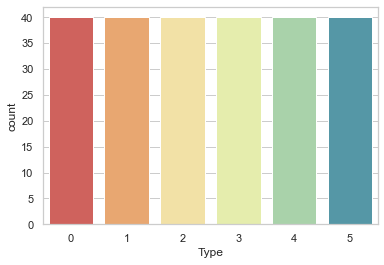

In [13]:
# График распределения типов звёзд
with sns.axes_style('whitegrid'):
    sns.countplot(data=data, x='Type', palette='Spectral')
    plt.show()


### Обработка данных


In [14]:
# Значение в столбце Color
data['Color'].value_counts()

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: Color, dtype: int64

Как видно из таблице у нас есть часть значений, которые по факту являются одним и тем же. Например, White и white.

Обработаем данные значения:

In [15]:
# Cписок цветов под замену
colors = ['Blue-white', 'Blue White', 'Blue white', 'yellow-white', 'Yellowish White', 'yellowish', 'Yellowish', 'White-Yellow',
          'white', 'Whitish', 'Pale yellow orange', 'Orange-Red']

# Замена цветов
for i in range(len(data['Color'])):
    if data['Color'][i] in colors [:3]:
        data.loc[i, 'Color'] = 'Blue-White'
    elif data['Color'][i] in colors [3:8]:
        data.loc[i, 'Color'] = 'Yellow-White'
    elif data['Color'][i] in colors [8:10]:
        data.loc[i, 'Color'] = 'White'
    elif data['Color'][i] in colors [10:]:
        data.loc[i, 'Color'] = 'Orange'

In [16]:
# Проверка замены цветов
data['Color'].value_counts()

Red             112
Blue             56
Blue-White       41
Yellow-White     15
White            12
Orange            4
Name: Color, dtype: int64

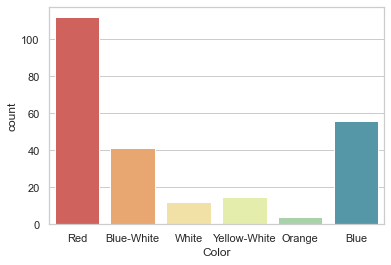

In [17]:
# График количества цветов
with sns.axes_style('whitegrid'):
    sns.countplot(data=data, x='Color', palette='Spectral')
    plt.show()


### Кодирование категориальных признаков


In [18]:
# One-hot кодирование признаков Color и Spectral_Class
data_encoded = pd.get_dummies(data, columns=['Color', 'Spectral_Class'])

data_encoded.head()

,Temperature,L,R,A_M,Type,Color_Blue,Color_Blue-White,Color_Orange,Color_Red,Color_White,Color_Yellow-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Проведём перестановку столбцов:

In [19]:
data_encoded = data_encoded[['Temperature', 'L', 'R', 'A_M',
                             'Color_Blue', 'Color_Blue-White', 'Color_White', 'Color_Yellow-White', 'Color_Orange', 'Color_Red',
                             'Spectral_Class_O', 'Spectral_Class_B', 'Spectral_Class_A', 'Spectral_Class_F',
                             'Spectral_Class_G', 'Spectral_Class_K', 'Spectral_Class_M', 'Type']]

data_encoded.head()

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_White,Color_Yellow-White,Color_Orange,Color_Red,Spectral_Class_O,Spectral_Class_B,Spectral_Class_A,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Type
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,1,0,0,0,0,0,0,1,0



### Масштабирование данных

Промасштабируем данные с помощью Z-оценки:

In [20]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_encoded.drop(columns=['Type']))

In [21]:
# Вставка отмасштабированных данных
data_scaled = pd.DataFrame(scaled_features, columns=data_encoded.columns[:-1])

data_scaled.head()

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_White,Color_Yellow-White,Color_Orange,Color_Red,Spectral_Class_O,Spectral_Class_B,Spectral_Class_A,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M
0,-0.779382,-0.598624,-0.459210,1.116745,-0.551677,-0.453905,-0.229416,-0.258199,-0.130189,1.069045,-0.447214,-0.486943,-0.293211,-0.276104,-0.064685,-0.160128,1.078036
1,-0.782110,-0.598624,-0.459241,1.162414,-0.551677,-0.453905,-0.229416,-0.258199,-0.130189,1.069045,-0.447214,-0.486943,-0.293211,-0.276104,-0.064685,-0.160128,1.078036
2,-0.828477,-0.598624,-0.459342,1.362213,-0.551677,-0.453905,-0.229416,-0.258199,-0.130189,1.069045,-0.447214,-0.486943,-0.293211,-0.276104,-0.064685,-0.160128,1.078036
3,-0.807496,-0.598624,-0.459229,1.167171,-0.551677,-0.453905,-0.229416,-0.258199,-0.130189,1.069045,-0.447214,-0.486943,-0.293211,-0.276104,-0.064685,-0.160128,1.078036
4,-0.897819,-0.598624,-0.459340,1.491607,-0.551677,-0.453905,-0.229416,-0.258199,-0.130189,1.069045,-0.447214,-0.486943,-0.293211,-0.276104,-0.064685,-0.160128,1.078036



### Разбиение выборки

In [22]:
X = data_scaled
y = data_encoded['Type']
y_features_name = ['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence', 'Super Giant', 'Hyper Giant']

X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [23]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((192, 17), (192,))

In [24]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((48, 17), (48,))

In [25]:
# Значения в обучающей выборке
y_train.value_counts()

1    36
3    35
0    33
5    30
4    29
2    29
Name: Type, dtype: int64

In [26]:
# Значения в тестовой выборке
y_test.value_counts()

4    11
2    11
5    10
0     7
3     5
1     4
Name: Type, dtype: int64


### Обучение модели

Обучим нашу модель с помощью метода K ближайших соседей. Пусть гиперпараметр K будет равен 5.

In [27]:
# Обучение модели (K = 5 — значение по умолчанию)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
# Предсказания обученной модели на тестовой выборке
knn_classifier_prediction = knn_classifier.predict(X_test)


### Оценка качества модели

#### 1. Точность (Accuracy)

In [29]:
# Метрика accuracy
accuracy_score(y_test, knn_classifier_prediction)

0.8958333333333334

In [30]:
def accuracy_score_for_classes(y_true : pd.Series,y_pred : np.ndarray) -> {int, float}:
    """
    Вычисление метрики accuracy для каждого класса

    :param y_true: Истинные значения целевого признака
    :param y_pred: Предсказанные моделью значения целевого признака
    :return: Словарь: ключ — метка класса, значение — accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame
    df = pd.DataFrame(data={'t': y_true, 'p': y_pred})
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # Фильтрация данных, которые соответствуют текущей метке класса в истинных значениях
        temp_data_flt = df[df['t'] == c]
        # Расчёт accuracy для заданной метки класса
        temp_acc = accuracy_score(temp_data_flt['t'].values, temp_data_flt['p'].values)
        # Сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(y_true : pd.Series, y_pred : np.ndarray):
    """
    Вывод метрики accuracy для каждого класса

    :param y_true: Истинные значения целевого признака
    :param y_pred: Предсказанные моделью значения целевого признака
    """
    accuracies = accuracy_score_for_classes(y_true, y_pred)
    if len(accuracies) > 0:
        print('Метка \t Accuracy')
    for a in accuracies:
        print('{} \t\t {}'.format(a, accuracies[a]))

In [31]:
# Метрика accuracy по классам
print_accuracy_score_for_classes(y_test, knn_classifier_prediction)

Метка 	 Accuracy
0 		 1.0
1 		 1.0
2 		 0.7272727272727273
3 		 1.0
4 		 1.0
5 		 0.8



#### 2. Матрица ошибок (Confusion matrix)


In [32]:
# Матрица ошибок
cm = confusion_matrix(y_test, knn_classifier_prediction)
cm

array([[ 7,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0],
       [ 0,  0,  8,  3,  0,  0],
       [ 0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0, 11,  0],
       [ 0,  0,  1,  1,  0,  8]], dtype=int64)

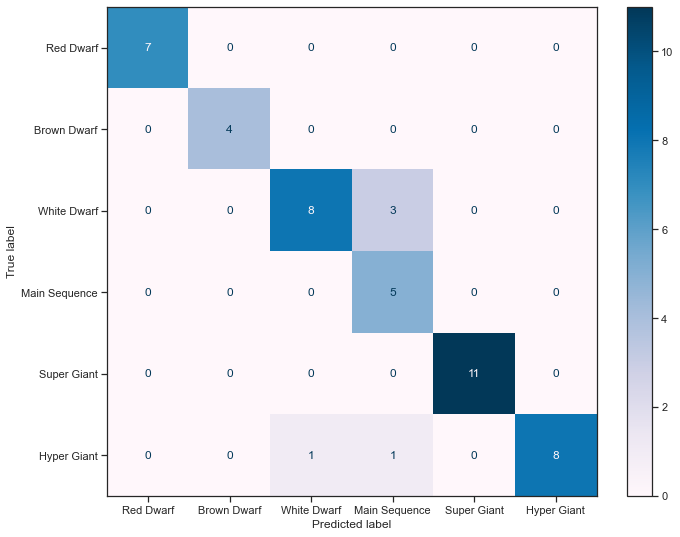

In [33]:
# Тепловая карта матрицы ошибок
fig, ax = plt.subplots(figsize=(11, 9))
cm_display = ConfusionMatrixDisplay(cm, display_labels=y_features_name)
cm_display.plot(cmap='PuBu', ax=ax)
plt.show()

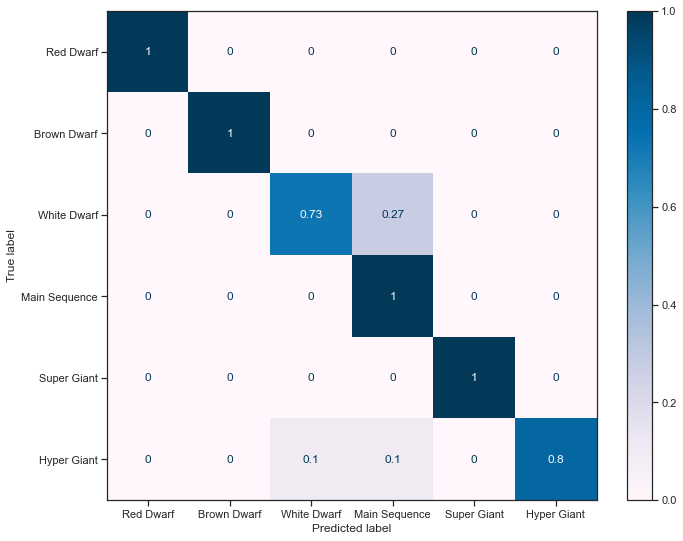

In [34]:
# Тепловая карта нормализованной матрицы ошибок
cm_normalized = confusion_matrix(y_test, knn_classifier_prediction, normalize='true')

_, ax = plt.subplots(figsize=(11, 9))
cm_norm_display = ConfusionMatrixDisplay(cm_normalized, display_labels=y_features_name)
cm_norm_display.plot(cmap='PuBu', ax=ax)
plt.show()

Выше мы задавали отображение тепловой карты матрицы ошибок с помощью конструктора класса ConfusionMatrixDisplay. Однако, гораздо проще (и рекомендовано разработчиками) это делать с помощью специальных методов класса: from_estimator — с помошью "оценщика" (модели-классификатора) и from_prediction — с помощью предсказания, сделанным моделью.

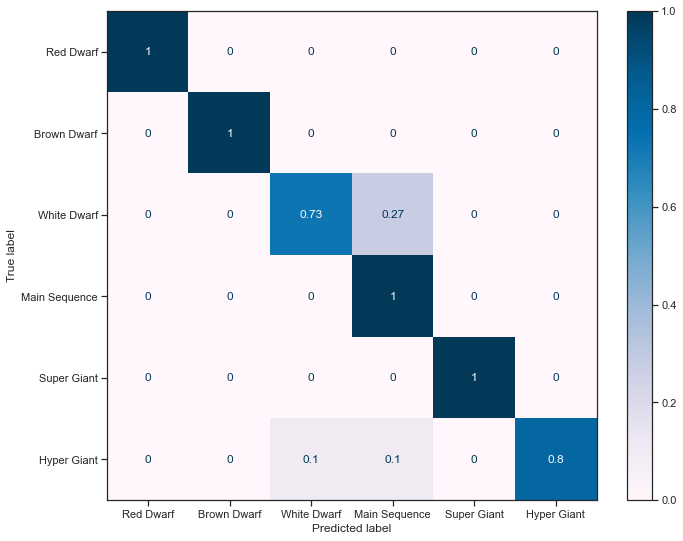

In [35]:
# Тепловая карта нормализованной матрицы ошибок, нарисованная с помощью метода from_estimator
_, ax = plt.subplots(figsize=(11, 9))
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_test, y_test, normalize='true',
                                                                  display_labels=y_features_name, ax=ax, cmap='PuBu')
plt.show()

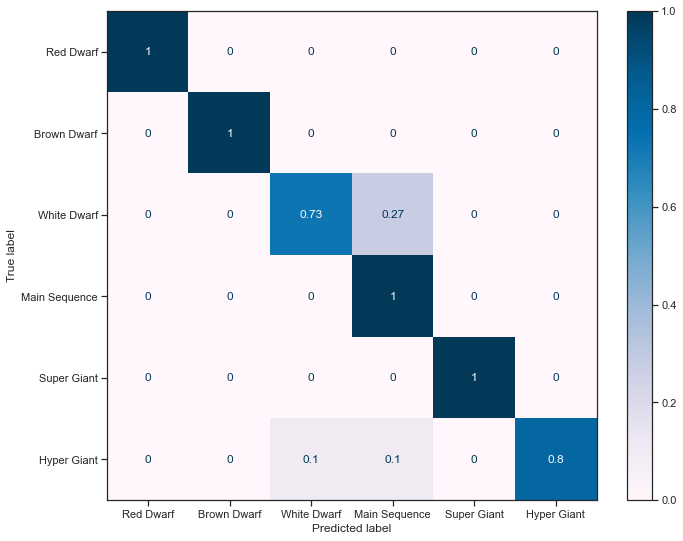

In [36]:
# Тепловая карта нормализованной матрицы ошибок, нарисованная с помощью метода from_prediction
_, ax = plt.subplots(figsize=(11, 9))
ConfusionMatrixDisplay.from_predictions(y_test, knn_classifier_prediction, normalize='true',
                                        display_labels=y_features_name, ax=ax, cmap='PuBu')
plt.show()


#### 3. Точность (precision), полнота (recall) и F-мера (F1)


In [37]:
# Точность (precision) c разным уровнем детализации метрик
print('Precission:')
print('Micro: {};'.format(precision_score(y_test, knn_classifier_prediction, average='micro')))
print('Macro: {};'.format(precision_score(y_test, knn_classifier_prediction, average='macro')))
print('Weighted: {};'.format(precision_score(y_test, knn_classifier_prediction, average='weighted')))
print('None: {}.'.format(precision_score(y_test, knn_classifier_prediction, average=None)))

Precission:
Micro: 0.8958333333333334;
Macro: 0.9074074074074074;
Weighted: 0.9282407407407408;
None: [1.         1.         0.88888889 0.55555556 1.         1.        ].


In [38]:
# Полнота (recall) c разным уровнем детализации метрик
print('Recall:')
print('Micro: {};'.format(recall_score(y_test, knn_classifier_prediction, average='micro')))
print('Macro: {};'.format(recall_score(y_test, knn_classifier_prediction, average='macro')))
print('Weighted: {};'.format(recall_score(y_test, knn_classifier_prediction, average='weighted')))
print('None: {}.'.format(recall_score(y_test, knn_classifier_prediction, average=None)))

Recall:
Micro: 0.8958333333333334;
Macro: 0.9212121212121213;
Weighted: 0.8958333333333334;
None: [1.         1.         0.72727273 1.         1.         0.8       ].


In [39]:
# F-мера (F1) c разным уровнем детализации метрик
print('F1 score:')
print('Micro: {};'.format(f1_score(y_test, knn_classifier_prediction, average='micro')))
print('Macro: {};'.format(f1_score(y_test, knn_classifier_prediction, average='macro')))
print('Weighted: {};'.format(f1_score(y_test, knn_classifier_prediction, average='weighted')))
print('None: {}.'.format(f1_score(y_test, knn_classifier_prediction, average=None)))

F1 score:
Micro: 0.8958333333333334;
Macro: 0.9005291005291006;
Weighted: 0.9012566137566136;
None: [1.         1.         0.8        0.71428571 1.         0.88888889].


In [40]:
# Отчёт по классификации
print(classification_report(y_test, knn_classifier_prediction, target_names=y_features_name))

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00         7
  Brown Dwarf       1.00      1.00      1.00         4
  White Dwarf       0.89      0.73      0.80        11
Main Sequence       0.56      1.00      0.71         5
  Super Giant       1.00      1.00      1.00        11
  Hyper Giant       1.00      0.80      0.89        10

     accuracy                           0.90        48
    macro avg       0.91      0.92      0.90        48
 weighted avg       0.93      0.90      0.90        48




#### 4. ROC-кривая и ROC AUC

ROC-кривая обычно используется для бинарной классификации. Поэтому для её построения для задачи мультиклассовой классификации "бинаризируем" наши метки класса, обучим ещё одну модель и будем строить ROC-кривую для каждого класса. Данные кривые не будут участвовать в сравнении моделей.

In [41]:
from sklearn.preprocessing import label_binarize

# Бинаризация целевого признака
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

# Обучение бинаризированной (многометочной) модели
knn_classifier_bin = KNeighborsClassifier()
knn_classifier_bin.fit(X_train, y_train_bin)
knn_classifier_prediction_bin = knn_classifier_bin.predict(X_test)

In [42]:
# Метрики бинаризированной модели
print(classification_report(y_test_bin, knn_classifier_prediction_bin, target_names=y_features_name, zero_division=1))

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00         7
  Brown Dwarf       1.00      1.00      1.00         4
  White Dwarf       1.00      0.55      0.71        11
Main Sequence       0.56      1.00      0.71         5
  Super Giant       1.00      1.00      1.00        11
  Hyper Giant       1.00      0.80      0.89        10

    micro avg       0.91      0.85      0.88        48
    macro avg       0.93      0.89      0.88        48
 weighted avg       0.95      0.85      0.88        48
  samples avg       0.92      0.85      0.85        48



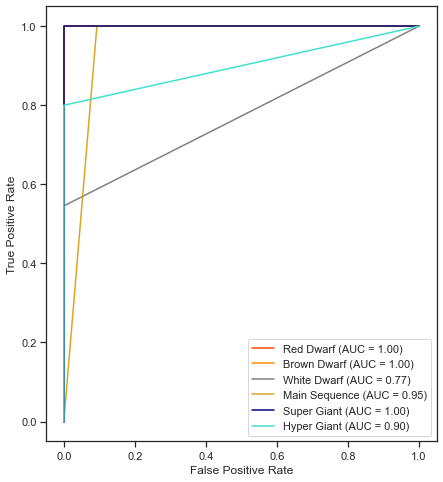

In [43]:
# ROC-кривые для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

_, ax = plt.subplots(figsize=(7, 8))
color = ['orangered', 'darkorange', 'grey', 'goldenrod','navy', 'turquoise']

for i in range(y_train_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn_classifier_prediction_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for j in range(y_train_bin.shape[1]):
    roc_display = RocCurveDisplay(fpr=fpr[j], tpr=tpr[j], roc_auc=roc_auc[j], estimator_name=y_features_name[j])
    roc_display.plot(ax=ax, color=color[j])

plt.show()

У класса RocCurveDisplay также как и класса ConfusionMatrixDispaly есть методы from_estimator и from_prediction для более простого построения кривых. Ниже пример с использованием метода from_prediction.

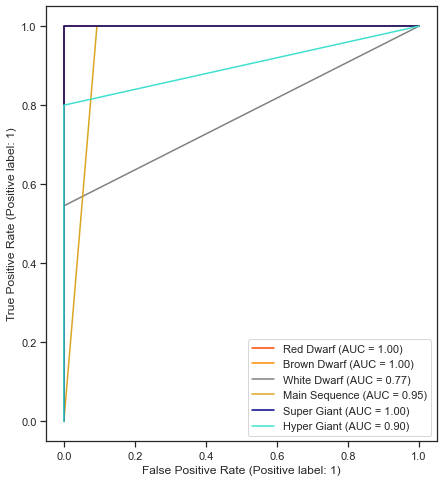

In [44]:
# Другой более простой способ построения ROC-кривых
_, ax = plt.subplots(figsize=(7, 8))

for j in range(y_train_bin.shape[1]):
    RocCurveDisplay.from_predictions(y_true=y_test_bin[:, j], y_pred=knn_classifier_prediction_bin[:, j],
                                                             name=y_features_name[j], ax=ax, color=color[j])

plt.show()

Теперь перейдём к метрике ROC AUC, которая удобно применима для случая мультиклассовой классификации:

In [45]:
# Предсказание вероянтностей тестовой выборки
knn_classifier_prob = knn_classifier.predict_proba(X_test)
knn_classifier_prob[:5]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [46]:
# ROC AUC с конфигурацией OvO
print('One vs One configuration:')
print('Macro: {};'.format(roc_auc_score(y_test, knn_classifier_prob, average='macro', multi_class='ovo')))
print('Weighted: {}.'.format(roc_auc_score(y_test, knn_classifier_prob, average='weighted', multi_class='ovo')))

One vs One configuration:
Macro: 0.9963939393939394;
Weighted: 0.9960511363636364.


In [47]:
# ROC AUC с конфигурацией OvR
print('One vs Rest configuration:')
print('Macro: {};'.format(roc_auc_score(y_test, knn_classifier_prob, average='macro', multi_class='ovr')))
print('Weighted: {}.'.format(roc_auc_score(y_test, knn_classifier_prob, average='weighted', multi_class='ovr')))

One vs Rest configuration:
Macro: 0.9957224750064407;
Weighted: 0.9957363651901595.



#### 5. Кривая presicion-recall

Построим кривую presicion-recall, несмторя на то, что классы у нас сбалансированы. Данная метрика не будет участвовать в сравнении также, как и ROC-кривые

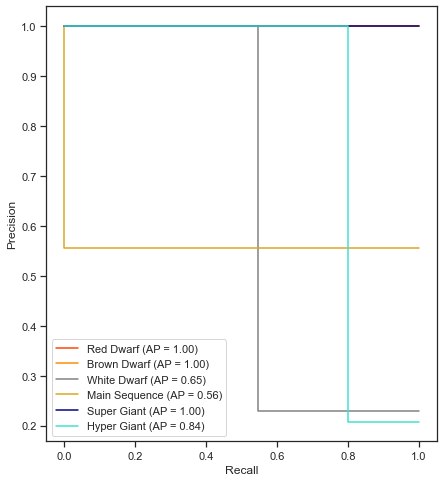

In [48]:
# Построение кривых precision-recall для каждого класса
precision = dict()
recall = dict()
average_precision = dict()

_, ax = plt.subplots(figsize=(7, 8))

for i in range(y_train_bin.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], knn_classifier_prediction_bin[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], knn_classifier_prediction_bin[:, i])

for j in range(y_train_bin.shape[1]):
    pr_display =PrecisionRecallDisplay(precision[j], recall[j], average_precision=average_precision[j],
                                       estimator_name=y_features_name[j])
    pr_display.plot(ax=ax, color=color[j])

plt.show()

Аналогично классам ConfusionMatrixDisplay и RocCurveDisplay, класс PrecisionRecallDisplay имеет методы from_estimator и from_prediction для построения кривых. Ниже пример с использованием метода from_prediction.

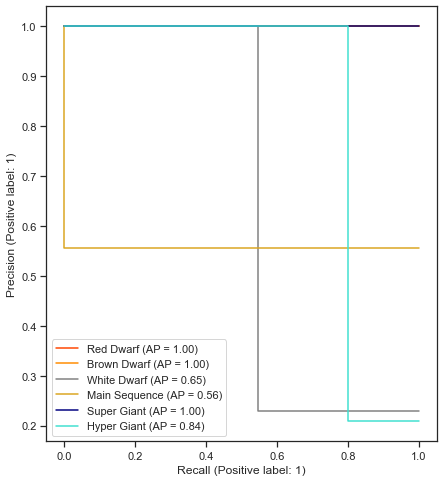

In [49]:
# Простой метод построения кривых precision-recall
_, ax = plt.subplots(figsize=(7, 8))

for j in range(y_train_bin.shape[1]):
    PrecisionRecallDisplay.from_predictions(y_test_bin[:, j], knn_classifier_prediction_bin[:, j],
                                                                   name=y_features_name[j], ax=ax, color=color[j])

plt.show()


#### 6. Логиcтическая функция потерь


In [50]:
# Логистическая функция потерь
log_loss(y_test, knn_classifier_prob)

0.20238656118808396


### Оценка качества модели c использованием кросс-валидации

Для оценки качества моедли с использованием кросс-валидации будем использовать взвешенную F1-меру (f1_weighted). Для некоторых стратегий кросс-валидациий (K-Fold и Stratified K-Fold) будем также исользовать дополнительные метрики, которые представлены ниже.

In [51]:
# Метрики, которые будут использоваться при оценки качества модели
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovo_weighted']


#### 1. K-Fold


In [52]:
# Оценка качества модели через стратегию K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=KFold(n_splits=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[1.         0.34541063 0.97222222 0.95883941 0.89844055 1.
 0.95743146 0.84444444 1.         0.69230769]
Mean: 0.8669096396441933


In [53]:
# Оценка качества модели через стратегию K-Fold с помощью метода cross_validate
# Разбиения всего два, так как при большем их количестве возникают предупреждения UndefinedMetricWarning
cross_validate(KNeighborsClassifier(), X, y, cv=KFold(n_splits=2), scoring=scoring, return_train_score=True)

{'fit_time': array([0., 0.]),
 'score_time': array([0.04686379, 0.03124356]),
 'test_accuracy': array([0.73333333, 0.74166667]),
 'train_accuracy': array([0.95833333, 0.91666667]),
 'test_precision_weighted': array([0.82700922, 0.80780423]),
 'train_precision_weighted': array([0.96139971, 0.91678692]),
 'test_recall_weighted': array([0.73333333, 0.74166667]),
 'train_recall_weighted': array([0.95833333, 0.91666667]),
 'test_f1_weighted': array([0.72988875, 0.70475669]),
 'train_f1_weighted': array([0.95820989, 0.9158622 ]),
 'test_roc_auc_ovo_weighted': array([0.92533333, 0.91675   ]),
 'train_roc_auc_ovo_weighted': array([0.99883333, 0.993125  ])}


#### 2. Repeated K-Fold


In [54]:
# Оценка качества модели через стратегию K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.97936508 0.93297119 0.91675473 0.9578514  0.91730392 0.91698285
 0.84785354 0.93860769 0.89169454 0.97908497 0.95833333 0.87801932
 1.         0.91701681 0.87632275 0.89655544 0.97897813 0.87172619
 0.95833333 0.87688286 0.95630411 0.89583333 0.91488231 0.97924837
 0.95581004]
Mean: 0.9277086495632464



#### 3. Leave-One-Out


In [55]:
# Оценка качества модели через стратегию Leave-One-Out
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=LeaveOneOut(), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
Mean: 0.9375



#### 4. Leave-P-Out


In [56]:
# Оценка качества модели через стратегию Leave-P-Out
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=LeavePOut(2), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[1.         1.         1.         ... 0.         0.66666667 0.66666667]
Mean: 0.9371222687122269



#### 5. ShuffleSplit


In [57]:
# Оценка качества модели через стратегию ShuffleSplit
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.91860535 0.98375758 0.95069444 0.89780659 0.86564111 0.89916226
 0.93485265 0.9198061  0.91638173 0.84563188]
Mean: 0.9132339690013443



#### 6. Stratified K-Fold


In [58]:
# Оценка качества модели через стратегию Stratified K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=StratifiedKFold(n_splits=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.95767196 0.82222222 0.82777778 0.95767196 0.91904762 0.95767196
 0.91534392 0.91111111 1.         0.91111111]
Mean: 0.9179629629629631


In [59]:
# Оценка качества модели через стратегию Stratified K-Fold с помощью метода cross_validate
# Разбиения всего два, так как при большем их количестве возникают предупреждения UndefinedMetricWarning
cross_validate(KNeighborsClassifier(), X, y, cv=StratifiedKFold(n_splits=2), scoring=scoring, return_train_score=True)

{'fit_time': array([0., 0.]),
 'score_time': array([0.01562071, 0.03124237]),
 'test_accuracy': array([0.73333333, 0.74166667]),
 'train_accuracy': array([0.95833333, 0.91666667]),
 'test_precision_weighted': array([0.82700922, 0.80780423]),
 'train_precision_weighted': array([0.96139971, 0.91678692]),
 'test_recall_weighted': array([0.73333333, 0.74166667]),
 'train_recall_weighted': array([0.95833333, 0.91666667]),
 'test_f1_weighted': array([0.72988875, 0.70475669]),
 'train_f1_weighted': array([0.95820989, 0.9158622 ]),
 'test_roc_auc_ovo_weighted': array([0.92533333, 0.91675   ]),
 'train_roc_auc_ovo_weighted': array([0.99883333, 0.993125  ])}


#### 7. Repeated Stratified K-Fold


In [60]:
# Оценка качества модели через стратегию Repeated Stratified K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.90038638 0.93321602 0.97908497 0.9372549  0.95767196 0.87487469
 0.97908497 0.91360818 0.93842593 0.95825163 0.97908497 0.88671024
 0.95825163 0.87531902 0.93876358 0.9372549  0.95825163 0.93675692
 0.93321602 0.85517881 0.91614146 0.95816993 0.97908497 0.87902272
 0.95816993]
Mean: 0.9328494545816528



#### 8. Stratified ShuffleSplit


In [61]:
# Оценка качества модели через стратегию Stratified ShuffleSplit
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.88055556 0.88041126 0.93218244 0.91496053 0.89990663 0.89783691
 0.9666249  0.88167218 0.96632997 0.95097042]
Mean: 0.9171450779419551



### Подбор гиперпараметра K

Для подбора гиперпараметра K будем использовать следующие стратегии кросс-валидации: K-Fold, Leave-One-Out, Stratified K-Fold, Repeated Stratified K-Fold, Stratified, ShuffleSplit. Оптимизировать будем по взешенной F1-мере

In [62]:
# Диапазон гиперпараметра K для оптимизации
n_range = np.array(range(1, 21, 1))
parameters_to_tune = [{'n_neighbors' : n_range}]
parameters_to_tune

[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20])}]


#### 1. Решетчатый поиск

##### 1.1 K-Fold


In [63]:
%%time
# Решетчатый поиск со стратегией K-Fold
clf_gs_k_fold= GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=KFold(n_splits=10), scoring='f1_weighted')
clf_gs_k_fold.fit(X, y)

CPU times: total: 4.28 s
Wall time: 720 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [64]:
# Лучшее значение гиперпараметра
clf_gs_k_fold.best_params_

{'n_neighbors': 1}

In [65]:
# Лучшее значение метрики
clf_gs_k_fold.best_score_

0.941294773194928

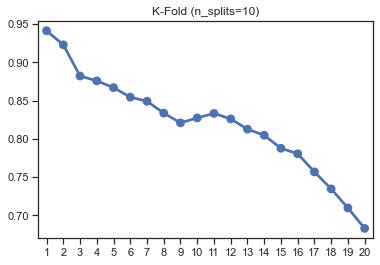

In [66]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_k_fold.cv_results_['mean_test_score'])
plt.title('K-Fold (n_splits=10)')
plt.show()


##### 1.2 Leave-One-Out


In [67]:
%%time
# Решетчатый поиск со стратегией Leave-One-Out
clf_gs_loo = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=LeaveOneOut(), scoring='f1_weighted')
clf_gs_loo.fit(X, y)

CPU times: total: 13.6 s
Wall time: 13.7 s


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [68]:
# Лучшее значение гиперпараметра
clf_gs_loo.best_params_

{'n_neighbors': 1}

In [69]:
# Лучшее значение метрики
clf_gs_loo.best_score_

0.9583333333333334

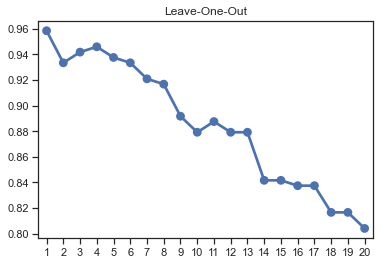

In [70]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_loo.cv_results_['mean_test_score'])
plt.title('Leave-One-Out')
plt.show()


##### 1.3 Stratified K-Fold


In [71]:
%%time
# Решетчатый поиск со стратегией Stratified K-Fold
clf_gs_s_k_fold = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedKFold(n_splits=10), scoring='f1_weighted')
clf_gs_s_k_fold.fit(X, y)

CPU times: total: 4.02 s
Wall time: 695 ms


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [72]:
# Лучшее значение гиперпараметра
clf_gs_s_k_fold.best_params_

{'n_neighbors': 3}

In [73]:
# Лучшее значение метрики
clf_gs_s_k_fold.best_score_

0.9404365079365078

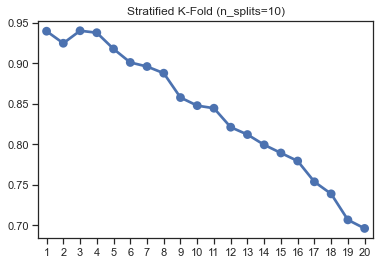

In [74]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_s_k_fold.cv_results_['mean_test_score'])
plt.title('Stratified K-Fold (n_splits=10)')
plt.show()


##### 1.4 Repeated Stratified K-Fold


In [75]:
%%time
# Решетчатый поиск со стратегией Repeated Stratified K-Fold
clf_gs_rep_s_k_fold = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5), scoring='f1_weighted')
clf_gs_rep_s_k_fold.fit(X, y)

CPU times: total: 11.9 s
Wall time: 2.08 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [76]:
# Лучшее значение гиперпараметра
clf_gs_rep_s_k_fold.best_params_

{'n_neighbors': 1}

In [77]:
# Лучшее значение метрики
clf_gs_rep_s_k_fold.best_score_

0.9515360270963985

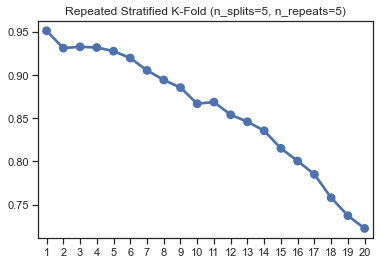

In [78]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_rep_s_k_fold.cv_results_['mean_test_score'])
plt.title('Repeated Stratified K-Fold (n_splits=5, n_repeats=5)')
plt.show()


##### 1.5 Stratified ShuffleSplit


In [79]:
%%time
# Решетчатый поиск со стратегией Stratified ShuffleSplit
clf_gs_s_sfl_splt = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=10),
                                   scoring='f1_weighted')
clf_gs_s_sfl_splt.fit(X, y)

CPU times: total: 4.91 s
Wall time: 935 ms


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=10, test_size=0.25,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [80]:
# Лучшее значение гиперпараметра
clf_gs_s_sfl_splt.best_params_

{'n_neighbors': 1}

In [81]:
# Лучшее значение метрики
clf_gs_s_sfl_splt.best_score_

0.961190364503058

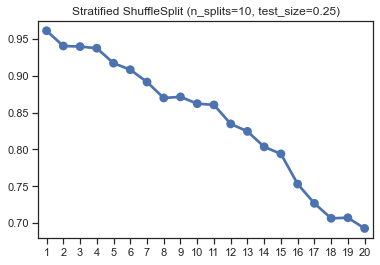

In [82]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_s_sfl_splt.cv_results_['mean_test_score'])
plt.title('Stratified ShuffleSplit (n_splits=10, test_size=0.25)')
plt.show()


#### 2. Случайный поиск

##### 2.1 K-Fold

In [83]:
%%time
# Случайный поиск со стратегией K-Fold
clf_rs_k_fold= RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=KFold(n_splits=10), scoring='f1_weighted', n_iter=20)
clf_rs_k_fold.fit(X, y)

CPU times: total: 3.48 s
Wall time: 782 ms


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [84]:
# Лучшее значение гиперпараметра
clf_rs_k_fold.best_params_

{'n_neighbors': 1}

In [85]:
# Лучшее значение метрики
clf_rs_k_fold.best_score_

0.941294773194928

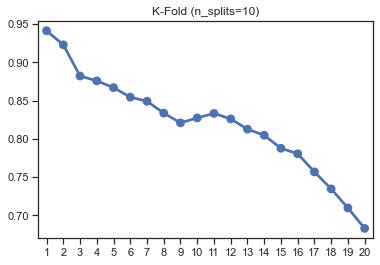

In [86]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_k_fold.cv_results_['mean_test_score'])
plt.title('K-Fold (n_splits=10)')
plt.show()


##### 2.2 Leave-One-Out


In [87]:
%%time
# Случайный поиск со стратегией Leave-One-Out
clf_rs_loo = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=LeaveOneOut(), scoring='f1_weighted', n_iter=20)
clf_rs_loo.fit(X, y)

CPU times: total: 13.8 s
Wall time: 14 s


RandomizedSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
                   n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [88]:
# Лучшее значение гиперпараметра
clf_rs_loo.best_params_

{'n_neighbors': 1}

In [89]:
# Лучшее значение метрики
clf_rs_loo.best_score_

0.9583333333333334

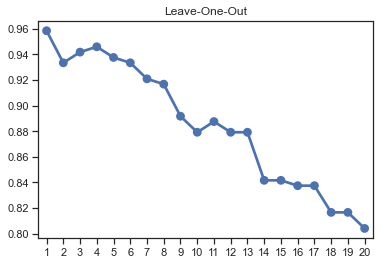

In [90]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_loo.cv_results_['mean_test_score'])
plt.title('Leave-One-Out')
plt.show()


##### 2.3 Stratified K-Fold


In [91]:
%%time
# Случайный поиск со стратегией Stratified K-Fold
clf_rs_s_k_fold = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedKFold(n_splits=10),
                                     scoring='f1_weighted', n_iter=20)
clf_rs_s_k_fold.fit(X, y)

CPU times: total: 3.81 s
Wall time: 731 ms


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [92]:
# Лучшее значение гиперпараметра
clf_rs_s_k_fold.best_params_

{'n_neighbors': 3}

In [93]:
# Лучшее значение метрики
clf_rs_s_k_fold.best_score_

0.9404365079365078

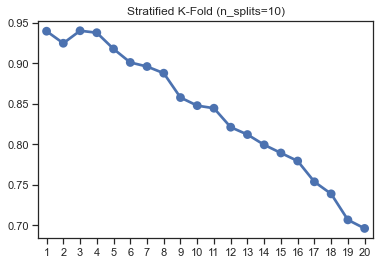

In [94]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_s_k_fold.cv_results_['mean_test_score'])
plt.title('Stratified K-Fold (n_splits=10)')
plt.show()


##### 2.4 Repeated Stratified K-Fold


In [95]:
%%time
# Случайный поиск со стратегией Repeated Stratified K-Fold
clf_rs_rep_s_k_fold = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5),
                                   scoring='f1_weighted', n_iter=20)
clf_rs_rep_s_k_fold.fit(X, y)

CPU times: total: 11.6 s
Wall time: 2.08 s


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [96]:
# Лучшее значение гиперпараметра
clf_rs_rep_s_k_fold.best_params_

{'n_neighbors': 1}

In [97]:
# Лучшее значение метрики
clf_rs_rep_s_k_fold.best_score_

0.956521753730732

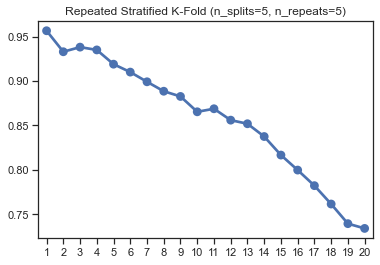

In [98]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_rep_s_k_fold.cv_results_['mean_test_score'])
plt.title('Repeated Stratified K-Fold (n_splits=5, n_repeats=5)')
plt.show()


##### 2.5 Stratified ShuffleSplit


In [99]:
%%time
# Случайный поиск со стратегией Stratified ShuffleSplit
clf_rs_s_sfl_splt = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=10),
                                     scoring='f1_weighted', n_iter=20)
clf_rs_s_sfl_splt.fit(X, y)

CPU times: total: 4.81 s
Wall time: 890 ms


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=10, test_size=0.25,
            train_size=None),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [100]:
# Лучшее значение гиперпараметра
clf_rs_s_sfl_splt.best_params_

{'n_neighbors': 1}

In [101]:
# Лучшее значение метрики
clf_rs_s_sfl_splt.best_score_

0.961190364503058

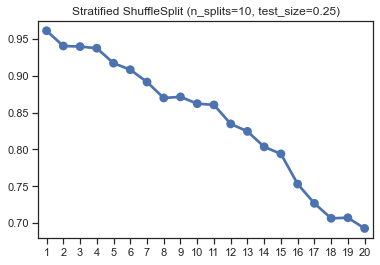

In [102]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_s_sfl_splt.cv_results_['mean_test_score'])
plt.title('Stratified ShuffleSplit (n_splits=10, test_size=0.25)')
plt.show()


### Обучение модели с оптимизированным гиперпараметром

В качестве оптимизированной модели возмём классификатор с гиперапараметром K = 1, найденным решетчатым поиском со стратегией Stratified ShuffleSplit, так как у него наиулчшее значение метрики (и отношение время/качество).

In [103]:
# Обучение модели c оптимизированным гиперпараметром
knn_classifier_optimized = clf_gs_s_sfl_splt.best_estimator_
knn_classifier_optimized.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [104]:
# Предсказания обученной модели на тестовой выборке
knn_classifier_optimized_prediction = knn_classifier_optimized.predict(X_test)
knn_classifier_optimized_prob = knn_classifier_optimized.predict_proba(X_test)


### Оценка качества модели с оптимизированным гиперпараметром
#### 1. Точность (Accuracy)


In [105]:
# Точности (Accuracies) старой и новой моделей
print('K = 5: {};\nK = 1: {}.'.format(accuracy_score(y_test, knn_classifier_prediction),
                                      accuracy_score(y_test, knn_classifier_optimized_prediction)))

K = 5: 0.8958333333333334;
K = 1: 0.9375.


In [106]:
# Метрика accuracy по классам старой модели
print('K = 5:')
print_accuracy_score_for_classes(y_test, knn_classifier_prediction)

K = 5:
Метка 	 Accuracy
0 		 1.0
1 		 1.0
2 		 0.7272727272727273
3 		 1.0
4 		 1.0
5 		 0.8


In [107]:
# Метрика accuracy по классам новой модели
print('K = 1:')
print_accuracy_score_for_classes(y_test, knn_classifier_optimized_prediction)

K = 1:
Метка 	 Accuracy
0 		 1.0
1 		 1.0
2 		 1.0
3 		 0.8
4 		 1.0
5 		 0.8



#### 2. Матрицы ошибок (Confusion matrix)


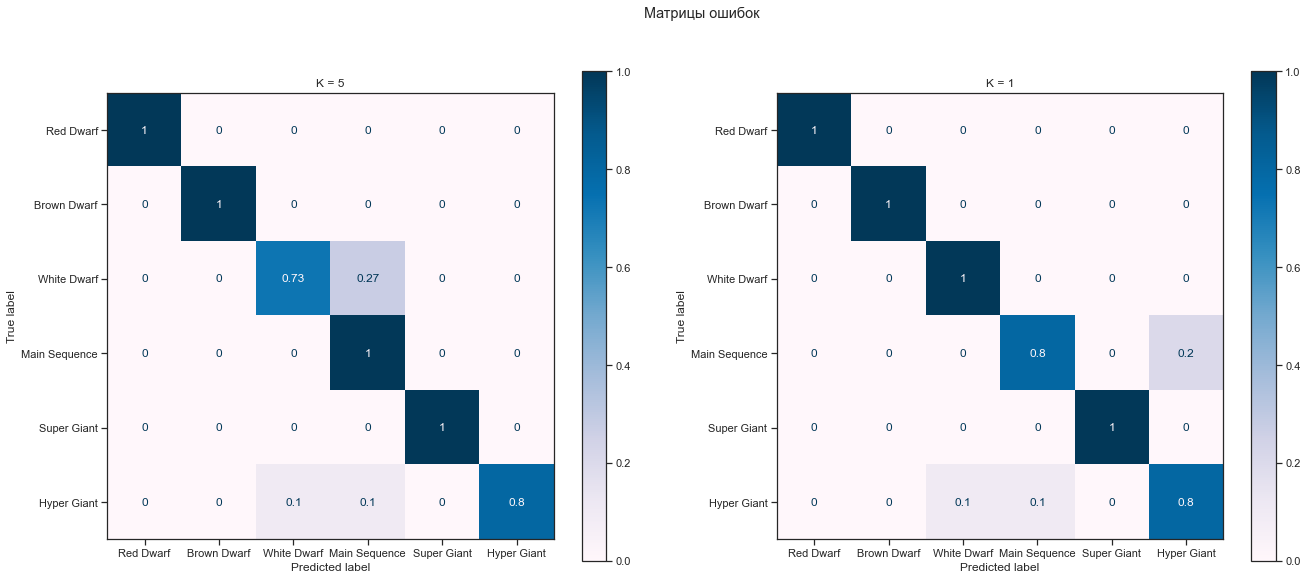

In [108]:
# Тепловые карты матриц ошибок
fig, ax = plt.subplots(1, 2, figsize=(22,9))
ConfusionMatrixDisplay.from_predictions(y_test, knn_classifier_prediction, normalize='true',
                                        display_labels=y_features_name, ax=ax[0], cmap='PuBu')
ConfusionMatrixDisplay.from_predictions(y_test, knn_classifier_optimized_prediction, normalize='true',
                                        display_labels=y_features_name, ax=ax[1], cmap='PuBu')
fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K = 5')
ax[1].title.set_text('K = 1')
plt.show()


#### 3. Точность (precision), полнота (recall) и F-мера (F1)


In [109]:
# Точности (Precissions) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(precision_score(y_test, knn_classifier_prediction, average='weighted'),
                                      precision_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.9282407407407408;
K = 1: 0.9369212962962962.


In [110]:
# Полноты (Recalls) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(recall_score(y_test, knn_classifier_prediction, average='weighted'),
                                      recall_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.8958333333333334;
K = 1: 0.9375.


In [111]:
# F-меры (F1) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(f1_score(y_test, knn_classifier_prediction, average='weighted'),
                                      f1_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.9012566137566136;
K = 1: 0.9363081617086193.


In [112]:
# Отчёт по классификации новой модели
print(classification_report(y_test, knn_classifier_optimized_prediction, target_names=y_features_name))

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00         7
  Brown Dwarf       1.00      1.00      1.00         4
  White Dwarf       0.92      1.00      0.96        11
Main Sequence       0.80      0.80      0.80         5
  Super Giant       1.00      1.00      1.00        11
  Hyper Giant       0.89      0.80      0.84        10

     accuracy                           0.94        48
    macro avg       0.93      0.93      0.93        48
 weighted avg       0.94      0.94      0.94        48




#### 4. ROC AUC


In [113]:
# ROC AUC старой и новой моделей (One vs One, взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(roc_auc_score(y_test, knn_classifier_prob, average='weighted', multi_class='ovo'),
                                      roc_auc_score(y_test, knn_classifier_optimized_prob, average='weighted', multi_class='ovo')))

K = 5: 0.9960511363636364;
K = 1: 0.9606250000000001.



#### 5. Логистическая функция потерь (log loss)


In [114]:
# Логистические функции потерь старой и новой моделей
print('K = 5: {};\nK = 1: {}.'.format(log_loss(y_test, knn_classifier_prob),
                                      log_loss(y_test, knn_classifier_optimized_prob)))

K = 5: 0.20238656118808396;
K = 1: 2.1586735246819235.


Как видно из сравнения оценок, новая модель выигрывает у старой по метрикам accuracy, precision, recall и F-мере, но проигрывает по ROC AUC и log loss.


### Построение кривых обучения и валидации


In [115]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

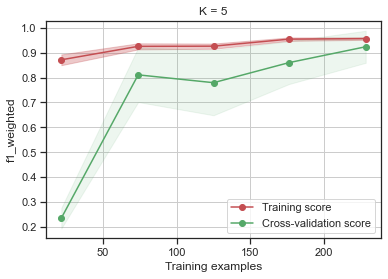

In [116]:
# Кривая обучения для первоначальной модели
plot_learning_curve(KNeighborsClassifier(), 'K = 5', X, y, cv=20, scoring='f1_weighted')
plt.show()

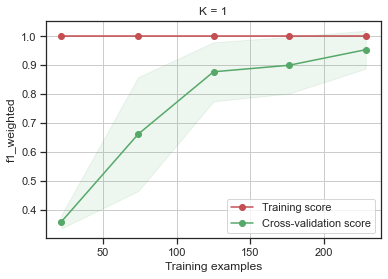

In [117]:
# Кривая обучения для модели с оптимизированным гиперпараметром
plot_learning_curve(clf_gs_s_sfl_splt.best_estimator_, 'K = 1', X, y, cv=20, scoring='f1_weighted')
plt.show()

In [118]:
def plot_validation_curve(estimator, title, X, y,
                          param_name, param_range, cv,
                          scoring='accuracy'):

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

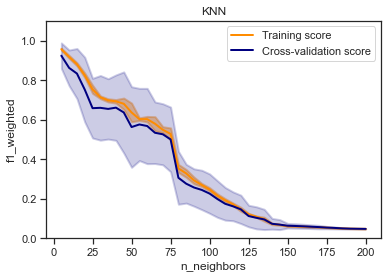

In [119]:
# Кривая валидации
n_range_for_val_curve = np.array(range(5,205,5))
plot_validation_curve(clf_gs_s_sfl_splt.best_estimator_, 'KNN',X, y,
                      param_name='n_neighbors', param_range=n_range_for_val_curve,
                      cv=20, scoring="f1_weighted")
plt.show()